In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Levenshtein import distance as lev_distance
from matplotlib.cm import get_cmap
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from tqdm.notebook import tqdm

# Data import

In [18]:
# Swadesh lists from Goolgle translate
data = pd.read_csv('Total_Google.csv', sep='|', encoding='utf-8')

# Data cleaning

## Normalization

In [19]:
for col in data.columns:
    #data[col] = data[col].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
    data[col] = data[col].str.lower()

In [20]:
data = data.set_index('Index').dropna(axis=1)

## Parsing of multiple translations

In [21]:
for col in data.columns:
    data[col] = data[col].str.replace(',', '')
    data[col] = data[col].apply(lambda x: x.split())

# Levenshtein distances

## Normalized Levenshtein distance

In [22]:
def normLevenshtein(word1, word2):
    return(lev_distance(word1, word2)/max(len(word1), len(word2)))

## List-wise normalized Levenshtein distance

In [23]:
def listLevenshtein(list1, list2):
    out = 1
    for w1 in list1:
        for w2 in list2:
            if normLevenshtein(w1, w2) < out:
                out = normLevenshtein(w1, w2)
    return(out)    

## pd.Series-wise normalized Levenshtein distance

In [24]:
def serieLevenshtein(s1, s2):
    df = pd.concat([s1, s2], axis=1)
    return(np.mean(df.apply(lambda row: listLevenshtein(row[s1.name], row[s2.name]), axis=1)))

## Normalized Levenshtein distance matrix

In [25]:
distances = np.zeros((len(data.columns), len(data.columns)))

In [26]:
for l1 in tqdm(range(0, len(data.columns))):
    col1 = data.columns[l1]
    for l2 in range(l1 + 1, len(data.columns)):
        col2 = data.columns[l2]
        distances[l1][l2] = serieLevenshtein(data[col1], data[col2])

  0%|          | 0/82 [00:00<?, ?it/s]

In [27]:
distances = distances + distances.T - np.diag(distances.diagonal())
distances_df = pd.DataFrame(distances)
distances_df.columns = data.columns
distances_df.index = data.columns

In [28]:
# distances_df.to_csv('distances.csv', sep=';')

# Clustering

## DBSCAN

In [29]:
dbs = DBSCAN(min_samples=3, eps=0.7, metric='precomputed')

In [30]:
dbs.fit(distances_df)

DBSCAN(eps=0.7, metric='precomputed', min_samples=3)

## MDS

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
embedding = MDS(dissimilarity='precomputed')

In [33]:
langspace = embedding.fit_transform(distances_df)

## Plot

In [34]:
# Custom colormap
my_cmap = get_cmap('hsv')
my_cmap.set_under('black')

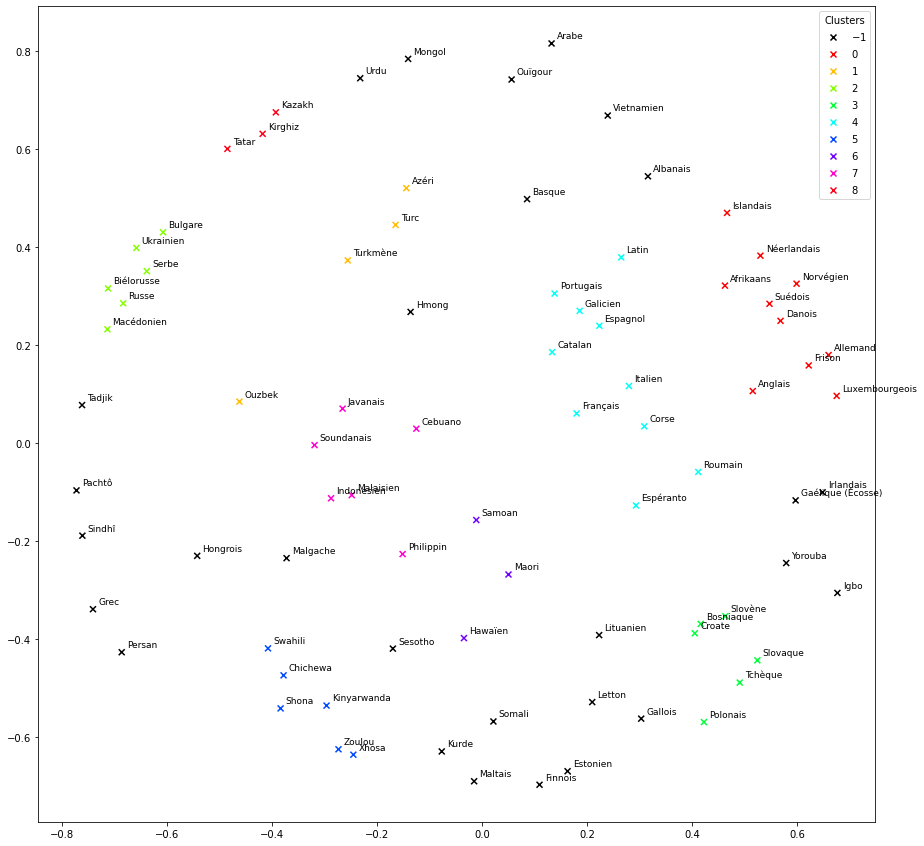

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))

# Scatter plot
x_coords = langspace[:, 0]
y_coords = langspace[: ,1]
scatter = ax.scatter(x_coords, y_coords, marker='x', c=dbs.labels_, cmap=my_cmap, vmin=0)

# Clusters legend
ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")

# Language legend
types = data.columns.values
for i,type in enumerate(types):
    x = x_coords[i]
    y = y_coords[i]
    decalage = 0.01
    plt.text(x + decalage, y + decalage, type, fontsize=9)

plt.show()